In [51]:
# IMPORTS
import copy
import glob
from imdb import IMDb
from itertools import cycle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nltk
import numpy as np
import random
import statistics
import subprocess
import textclean
import unicodedata

from __future__ import print_function
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from nltk.stem import PorterStemmer
from scipy.stats import binom
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import AffinityPropagation
from textclean import textclean
from nltk.tokenize import TweetTokenizer

# nltk.download('punkt')
nltk.download('tagsets')


[nltk_data] Downloading package tagsets to /home/karen/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [9]:
# CONSTANTS
NUM_FOLDS = 10
ACL_PATH = "aclImdb_v1/aclImdb/{}"
ACL_FOLDER_PATHS = [
    ACL_PATH.format("train/unsup/*"),
    ACL_PATH.format("train/pos/*"),
    ACL_PATH.format("train/neg/*"),
    ACL_PATH.format("test/pos/*"),
    ACL_PATH.format("test/neg/*")
]
ACL_URL_PATHS = [
    ACL_PATH.format("train/urls_unsup.txt"),
    ACL_PATH.format("train/urls_pos.txt"),
    ACL_PATH.format("train/urls_neg.txt"),
    ACL_PATH.format("test/urls_pos.txt"),
    ACL_PATH.format("test/urls_neg.txt")
]
PANG_POS_PATH = "POS-tokenized/POS/*"
PANG_NEG_PATH = "NEG-tokenized/NEG/*"
SEED = 0
NUM_FOLDS = 10
POS = 1
NEG = -1
R = 5000

### Functions

#### Fetch Data

In [12]:
def get_embeddings_training_set(folder_paths_list, url_paths_list):
    """Get all embeddings docs from folder_path_list"""
    all_docs = []
    for folder_path, url_path in zip(folder_paths_list, url_paths_list):
        folder_documents = _get_docs_from_folder(
            folder_path, url_path, pretokenised=False)
        all_docs.extend(folder_documents)
    return all_docs

def _get_docs_from_folder(folder_path, url_file_name=None, pretokenised=False):
    if url_file_name != None:
        move_id_dict = _get_movie_number_to_movie_id(url_file_name)
    files = glob.glob(folder_path)
    folder_documents = []
    tknzr = TweetTokenizer()
    for file_name in files:
        with open(file_name) as fp:
            doc_words = []
            if pretokenised:
                doc_words = [word.strip("\n") 
                             for word in fp.readlines()
                             if word]
            else:
                document = fp.read()
                doc_words = filter(None, tknzr.tokenize(document))
            
            if url_file_name == None:
                folder_documents.append(doc_words)
            else:
                movie_number = int(file_name.split("/")[-1].split("_")[0])
                folder_documents.append(
                    (move_id_dict[movie_number], doc_words))
                
    return folder_documents

def _get_movie_number_to_movie_id(url_file_name):
    movie_id_dict = {}
    with open(url_file_name) as fp:
        for index, line in enumerate(fp.readlines()):
            # Each line is expected to be a url such as:
            # http://www.imdb.com/title/tt0018515/usercomments
            movie_id = line.split("/")[4].lstrip("t")
            movie_id_dict[index] = movie_id
    return movie_id_dict

In [18]:
def write_embeddings_training_set_pos_tag(folder_paths_list):
    """Finds tags for each word in doc. Writes to disk. Returns it."""
    all_docs = []
    for folder_path in folder_paths_list:
        folder_documents = _write_pos_tag_for_folder(folder_path)
        all_docs.extend(folder_documents)
        return all_docs

def _write_pos_tag_for_folder(folder_path):
    files = glob.glob(folder_path)
    folder_documents = []
    tknzr = TweetTokenizer()
    for file_name in files: 
        with open(file_name) as fp:
            with open("tagged/{}_tagged.txt".format(
                file_name.split(".")[0]), "w+") as tag_fp:
                document = fp.read()
                doc_words = filter(None, tknzr.tokenize(document))
                tagged_doc_list = nltk.pos_tag(doc_words)
                to_print = "\n".join(["{}zzzz{}".format(word.encode('utf-8'), word_type.encode('utf-8'))
                            for (word,word_type) in tagged_doc_list])
                tag_fp.write(to_print)
                folder_documents.append(tagged_doc_list)
    return folder_documents

#### Visualisation

In [100]:
def plot_words_in_document(labelled_document, doc2vec_model):
    # Find word vectors
    words = []
    tags = []
    word_vectors = []
    for word, tag in labelled_document:
        try:
            vector = doc2vec_model.wv.get_vector(word)
            words.append("{} : {}".format(word, tag))
            word_vectors.append(vector)
            tags.append(tag)
        except:
            pass
    
    # Find document vector
    doc_words = [word for (word, label) in labelled_docs[0]]
    doc_vector = doc2vec_model.infer_vector(doc_words)
    words.append("DOCUMENT")
    word_vectors.append(doc_vector)
    tags.append("k")
    
    # Get mean distance between word types and doc vector
    # TODO: take into account repetitions
    colours, categories = colour_code_and_categories(word_vectors, tags)
    for tag, vectors in categories.items():
        mean_dist = mean_distance_to_document_vector(doc_vector, vectors)
        print("{}: {} ".format(tag, mean_dist))
        
    reduced_vectors = reduce_dimensions(word_vectors, 2)
    print(type(reduced_vectors[0]))
    
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")
    xs = [vector[0] for vector in reduced_vectors]
    ys = [vector[1] for vector in reduced_vectors]
    ax.scatter(xs, ys, c=colours)
    for x, y, label in zip(xs, ys, words):
        ax.annotate(label, (x, y))
    plt.show()

def colour_code_and_categories(vectors, tags):
    categories = dict()
    categories["noun"] = []
    categories["verb"] = []
    categories["adjective"] = []
    categories["adverb"] = []
    categories["determiner"] = []
    categories["preposition"] = []
    categories["other"] = []
    
    colours = []
    for vector, tag in zip(vectors, tags):
        if tag.startswith("NN") or tag.startswith("PRP") or tag.startswith("WP"):
            # NOUN
            colours.append("r")
            categories["noun"].append(vector)
        elif tag.startswith("VB") or tag.startswith("MD"):
            # VERB
            colours.append("g")
            categories["verb"].append(vector)
        elif tag.startswith("JJ"):
            # ADJECTIVE
            colours.append("b")
            categories["adjective"].append(vector)
        elif tag.startswith("RB") or tag.startswith("WRB"):
            # ADVERB
            colours.append("c") 
            categories["adverb"].append(vector)
        elif tag.startswith("DT") or tag.startswith("EX") or tag.startswith("WDT"):
            # DETERMINER
            colours.append("y") 
            categories["determiner"].append(vector)
        elif tag.startswith("IN") or tag.startswith("TO"):
            # PREPOSITION
            colours.append("m")
            categories["preposition"].append(vector)
        else:
            # OTHER
            colours.append("k")
            categories["other"].append(vector)
    return colours, categories

In [101]:
def mean_distance_to_document_vector(doc_vector, word_vectors):
#     doc_vector.astype(double)
#     word_vectors = word_vectors.astype(double)
    distances_to_doc_vector = [np.linalg.norm(word_vec-doc_vector)
                              for word_vec in word_vectors]
    
    distances_mean = sum(distances_to_doc_vector)/float(len(distances_to_doc_vector))
    return distances_mean

In [88]:
def reduce_dimensions(data, dimensions):
    return TSNE(n_components=dimensions).fit_transform(data)

noun: 3.24649495938 
determiner: 3.28067107762 
adverb: 3.26532182693 
adjective: 3.24319169521 
preposition: 3.25186920166 
verb: 3.29085959593 
other: 3.15635407539 
<type 'numpy.ndarray'>


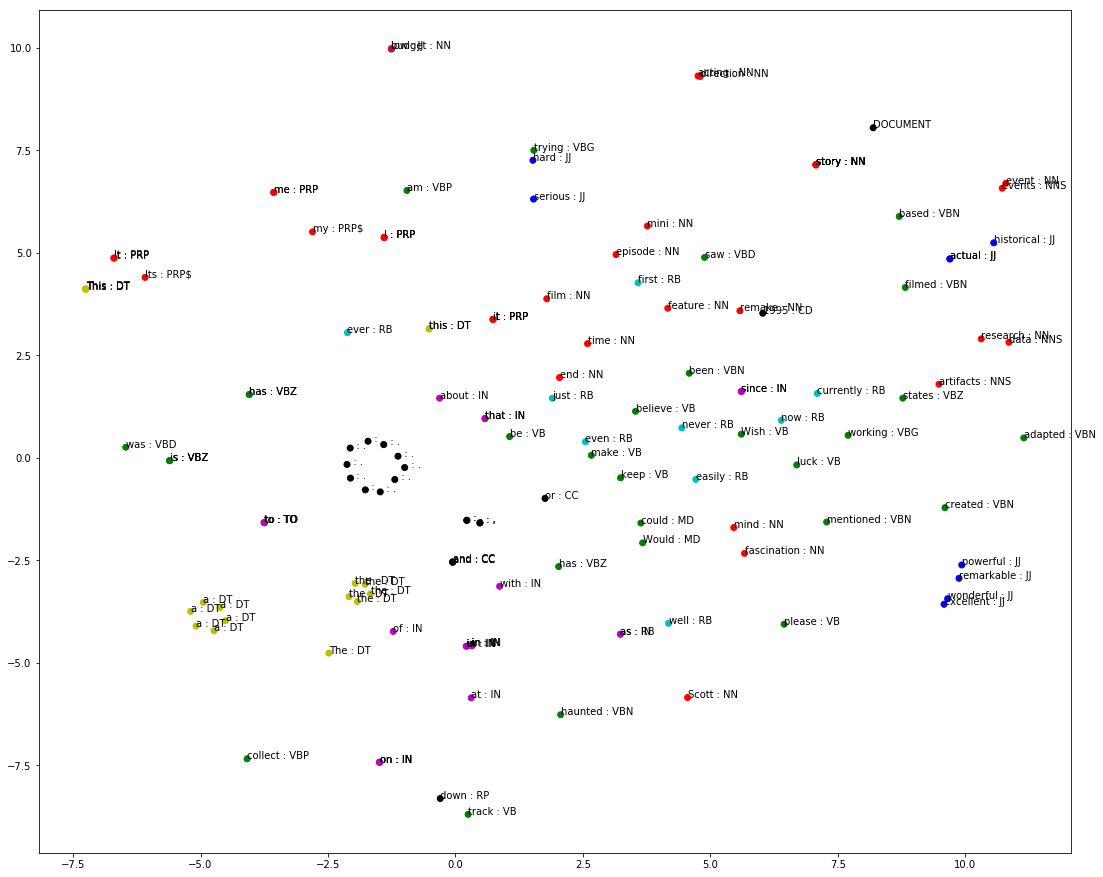

In [102]:
# PLOT SOME DOCUMENT WORD VECTORS AGAINST DOC VECTOR
plot_words_in_document(labelled_docs[0], doc2vec_model)


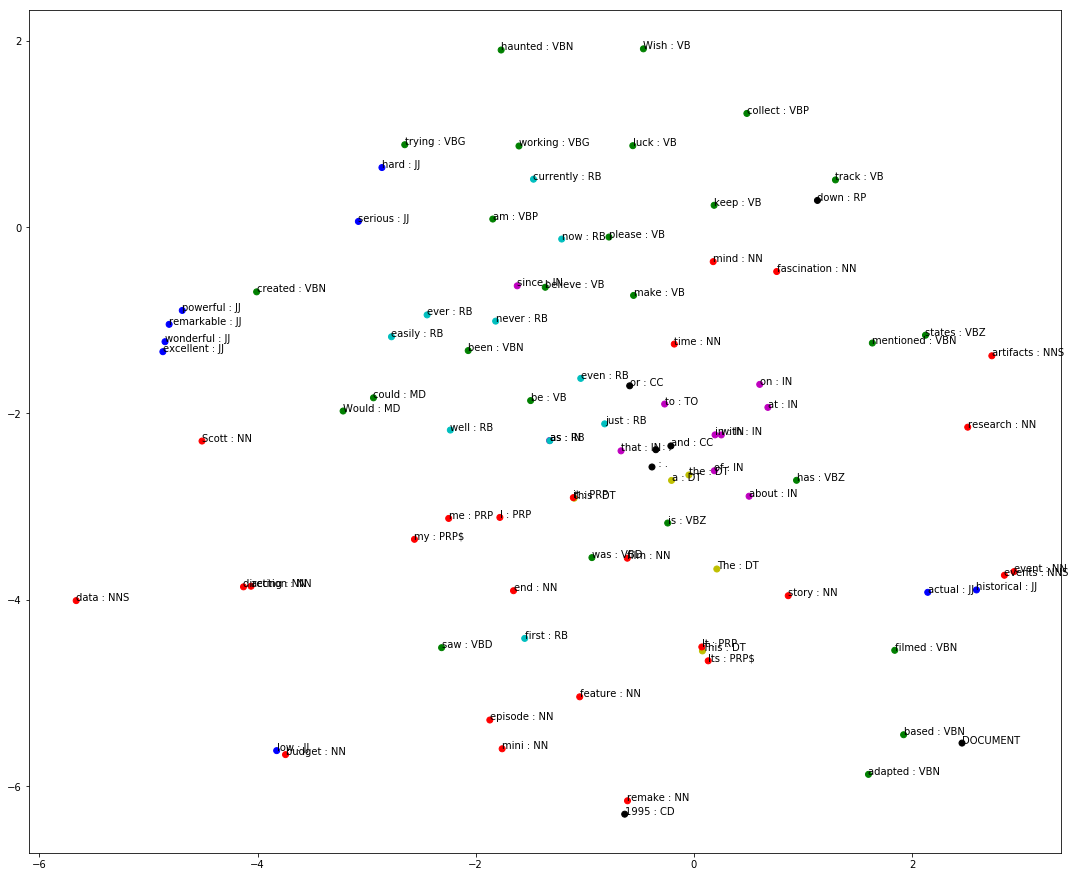

In [61]:
plot_words_in_document(labelled_docs[0], doc2vec_model)


In [104]:
# FIND FREQUENCY VS DISTANCE
def plot_words_in_document(labelled_document, doc2vec_model):
    # Find word frequencies
    word_counts = dict()
    
    # Find word vectors
    words = []
    tags = []
    word_vectors = []
    for word, tag in labelled_document:
        try:
            vector = doc2vec_model.wv.get_vector(word)
            words.append("{} : {}".format(word, tag))
            word_vectors.append(vector)
            tags.append(tag)
        except:
            pass
    
    # Find doc vectors
    doc_words = [word for (word, label) in labelled_docs[0]]
    doc_vector = doc2vec_model.infer_vector(doc_words)
    
    # Print distances
    for word, word_vector in zip(words, word_vectors):
        distance = np.linalg.norm(word_vector - doc_vector)
        print("{} : {}".format(word, distance))

plot_words_in_document(labelled_docs[0], doc2vec_model)

This : DT : 3.26128578186
Would : MD : 3.45963215828
make : VB : 3.31728672981
a : DT : 3.30659484863
excellent : JJ : 3.3167822361
remake : NN : 3.30655908585
, : , : 3.32745409012
just : RB : 3.35389447212
a : DT : 3.30659484863
remarkable : JJ : 3.42242765427
story : NN : 2.95653319359
. : . : 3.33902096748
The : DT : 3.47066569328
acting : NN : 3.46302723885
is : VBZ : 3.31677770615
wonderful : JJ : 3.35245680809
as : RB : 3.40895318985
well : RB : 3.30852818489
as : IN : 3.40895318985
the : DT : 3.29419851303
direction : NN : 3.45554256439
. : . : 3.33902096748
I : PRP : 3.31145811081
first : RB : 3.33026719093
saw : VBD : 3.49350357056
this : DT : 3.18680143356
episode : NN : 3.44444394112
in : IN : 3.30589437485
1995 : CD : 3.11770367622
, : , : 3.32745409012
and : CC : 3.36484622955
it : PRP : 3.14079189301
has : VBZ : 3.16538262367
haunted : VBN : 3.39455533028
me : PRP : 3.31584405899
ever : RB : 3.23141336441
since : IN : 3.09297442436
. : . : 3.33902096748
It : PRP : 3.1665

### Execution

In [19]:
# WRITE POS TAGS DOCS TO FILE
labelled_docs = write_embeddings_training_set_pos_tag(ACL_FOLDER_PATHS)

In [26]:
# RETRIEVE POS TAGS DOCS
# labelled_folder_paths = ["tagged/{}".format(folder)
#                          for folder in ACL_FOLDER_PATHS]
# labelled_docs = get_embeddings_training_set(
#     labelled_folder_paths, ACL_URL_PATHS)

print(labelled_docs)

[(u'This', 'DT'), (u'movie', 'NN'), (u'is', 'VBZ'), (u'so', 'RB'), (u'bad', 'JJ'), (u',', ','), (u'one', 'CD'), (u'wonders', 'VBZ'), (u'why', 'WRB'), (u'it', 'PRP'), (u'was', 'VBD'), (u'picked', 'VBN'), (u'for', 'IN'), (u'dubbing', 'VBG'), (u'and', 'CC'), (u'video', 'JJ'), (u'release', 'NN'), (u'.', '.'), (u'Check', 'VB'), (u'out', 'IN'), (u':', ':'), (u'the', 'DT'), (u'papier', 'NN'), (u'mache', 'NN'), (u'heads', 'NNS'), (u',', ','), (u'bad', 'JJ'), (u'African', 'NNP'), (u'makeup', 'NN'), (u',', ','), (u'the', 'DT'), (u'fire', 'NN'), (u'breathing', 'NN'), (u'exotic', 'JJ'), (u'dancer', 'NN'), (u',', ','), (u'and', 'CC'), (u'a', 'DT'), (u"'", "''"), (u'70', 'CD'), (u"'", 'POS'), (u's', 'JJ'), (u'look', 'NN'), (u'that', 'WDT'), (u'was', 'VBD'), (u'probably', 'RB'), (u'dated', 'VBN'), (u'when', 'WRB'), (u'this', 'DT'), (u'film', 'NN'), (u'was', 'VBD'), (u'released', 'VBN'), (u'.', '.'), (u'Please', 'VB'), (u"don't", 'JJ'), (u'anyone', 'NN'), (u'restore', 'NN'), (u'this', 'DT'), (u',', ',

In [31]:
# RETRIEVE DOC2VEC MODEL
doc2vec_file = get_tmpfile("my_doc2vec_model")
doc2vec_model = Doc2Vec.load(doc2vec_file)

In [32]:
doc2vec_model